## Import libraries

In [5]:
import pandas as pd
import seaborn as sns 
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder

In [4]:
pd.set_option("display.max_row", 40)

## Load the dataset

In [6]:
# X1: entry dataset (note: X2 is the testing dataset)
X1 = pd.read_csv("datasets/X1.csv")

print(X1.shape)
X1.head(5)

(3540, 14)


,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,\N,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


In [12]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       3540 non-null   int64  
 1   title            3540 non-null   object 
 2   img_url          3540 non-null   object 
 3   description      3540 non-null   object 
 4   ratings          3540 non-null   float64
 5   n_votes          3540 non-null   float64
 6   is_adult         3540 non-null   int64  
 7   production_year  3540 non-null   int64  
 8   runtime          3276 non-null   object 
 9   genres           3536 non-null   object 
 10  release_year     3540 non-null   float64
 11  studio           3540 non-null   object 
 12  img_embeddings   3540 non-null   object 
 13  text_embeddings  3540 non-null   object 
dtypes: float64(3), int64(3), object(8)
memory usage: 387.3+ KB


In [54]:
X1.loc[X1["title"] == "Clown"]

,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
38,7310,Clown,https://m.media-amazon.com/images/M/MV5BMjBiOD...,Clown: Directed by Steve Lyons. With Jeff Benn...,8.6,5.0,0,2001,\N,"Animation,Comedy,Family",2016.0,W/Dim.,"[0.14516667, 0.06064418, 0.15632975, 0.1824489...","[-0.65403396, 0.3780646, 0.999505, -0.97987425..."
2712,2587,Clown,https://m.media-amazon.com/images/M/MV5BMjBiOD...,Clown: Directed by Steve Lyons. With Jeff Benn...,8.6,5.0,0,2001,\N,"Animation,Comedy,Family",2016.0,W/Dim.,"[0.14516667, 0.06064418, 0.15632975, 0.1824489...","[-0.65403396, 0.3780646, 0.999505, -0.97987425..."


inputs dataset has dimension (3540, 14)

One first thing we can notice is that our dataset use a special character "\\N" for empty values. We should modify them to NaN.

In [19]:
# Y1: target dataset
Y1 = pd.read_csv("datasets/Y1.csv", header = None, names = ["revenues"])

print(Y1.shape)
Y1.head(5)

(3540, 1)


,revenues
0,7.158530e+07
1,8.964834e+04
2,3.164907e+07
3,3.898197e+07
4,9.697023e+06


target dataset has dimension (3540, 1)

## Dataset description

inputs (X1):     
- `title`: title of the movie.    
- `ratings`: rating on IMDB.    
- `n_votes`: number of votes that are averaged for the given rating.    
- `is_adult`: is the movie destined for a mature audience (0 or 1).    
- `production_year`: the year the movie was produced.    
- `release_year`: the year the movie was released.    
- `runtime`: how long the movie lasts for.    
- `genres`: a list of maximum 3 genres that fits the movie.   
- `studio`: the movie studio that produced the movie.        
- `img.url`: the url of the poster of the movie.    
- `img.embeddings`: vector of size 2048 representing the poster.    
- `description`: synopsis of the movie.    
- `text.embeddings`: vector of size 768 representing the synopsis.

There is also an `"Unnamed: 0"` column that seems to be an **id for the movie** to associate with the pandas index of the target dataset.

target (Y1):     
- `revenue`: the amount in dollars the movie made in the USA.    

## EDA and data engineering

What we're gonna do :
- Reencode some categorical variables and integers variables differently
- Remove useless / redondant features
- ...

First, let's rename `Unnamed: 0` column to `movie_id`

In [62]:
X1.columns = X1.columns.str.replace('Unnamed: 0','movie_id')
X1.head()

,movie_id,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,\N,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


### Types of variables

Let's check the different types of variables

In [20]:
# types of variables
X1.dtypes.value_counts()

object     8
int64      3
float64    3
dtype: int64

Among the 8 object variables, we have the **2 vectors embeddings**, the `img_url` and `description` features that we could drop since we have the embeddings.
We also have the following categorical variables: `title`, `genres` and `studio`.

We will drop `title` feature later.

In [21]:
X1.drop(columns=["img_url", "description"], inplace=True)
X1.head()

,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,\N,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


### Duplicated observations

Let's check if we have any duplicate observations (we saw before that there could be duplicated movies with different `movie_id`)

In [63]:
X1[X1.duplicated(subset=X1.columns.difference(["movie_id"]))]

,movie_id,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
190,6316,Patti Smith: Dream of Life,https://m.media-amazon.com/images/M/MV5BMjE3MD...,Patti Smith: Dream of Life: Directed by Steven...,7.1,978.0,0,2008,109,"Documentary,Music",2008.0,Palm,"[0.17170832, 1.569051, 0.27569252, 0.57657087,...","[-0.81552035, 0.4850951, 0.9999163, -0.9918469..."
191,8214,The Ox,https://m.media-amazon.com/images/M/MV5BMTg2OD...,The Ox: Directed by David Lowell Rich. With Bu...,8.2,13.0,0,1960,30,Western,1992.0,Castle,"[0.23510928, 4.0279293, 0.6071904, 0.2641873, ...","[-0.60471326, 0.30235755, 0.9994266, -0.976704..."
260,3854,Quiet City,https://m.media-amazon.com/images/M/MV5BMTQ0Mj...,Quiet City: Directed by Aaron Katz. With Erin ...,6.4,1394.0,0,2007,78,Drama,2007.0,600W,"[0.036631763, 0.20270766, 0.61714303, 0.378356...","[-0.6394012, 0.3269824, 0.9992954, -0.9756729,..."
298,7767,Stations of the Elevated,https://m.media-amazon.com/images/M/MV5BNjg2MT...,Stations of the Elevated: Directed by Manfred ...,7.4,119.0,0,1981,46,Documentary,2014.0,APD/C,"[0.09589887, 3.5422447, 0.16643104, 0.09537422...","[-0.6232235, 0.26639795, 0.9993814, -0.9771384..."
336,5368,The Objective,https://m.media-amazon.com/images/M/MV5BMTM3OT...,The Objective: Directed by Daniel Myrick. With...,5.5,7832.0,0,2008,90,"Horror,Sci-Fi,Thriller",2009.0,IFC,"[0.13143545, 0.77969044, 0.35194525, 0.8679075...","[-0.7277447, 0.42837766, 0.99979246, -0.982731..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3524,8827,Weekend of a Champion,https://m.media-amazon.com/images/M/MV5BMjA0Mz...,Weekend of a Champion: Directed by Frank Simon...,7.3,582.0,0,1972,80,"Action,Documentary,Sport",2013.0,SD,"[0.42331126, 4.12224, 0.4515665, 0.42120647, 0...","[-0.75798494, 0.4426181, 0.9999148, -0.9911467..."
3528,7551,I Can't Think Straight,https://m.media-amazon.com/images/M/MV5BODU4Nj...,I Can't Think Straight: Directed by Shamim Sar...,6.5,7872.0,0,2008,82,"Drama,Romance",2008.0,Reg.,"[0.13882937, 1.9479853, 1.2741721, 0.32582742,...","[-0.5699436, 0.3602491, 0.9995185, -0.9824196,..."
3530,7941,Great World of Sound,https://m.media-amazon.com/images/M/MV5BMTIxMT...,Great World of Sound: Directed by Craig Zobel....,6.7,1112.0,0,2007,106,"Comedy,Drama,Music",2007.0,Magn.,"[0.08482999, 1.7481948, 0.58276016, 0.30731, 0...","[-0.6863562, 0.3888457, 0.9996915, -0.98086303..."
3535,2787,Stiff Upper Lips,https://m.media-amazon.com/images/M/MV5BNGRiMz...,Stiff Upper Lips: Directed by Gary Sinyor. Wit...,6.3,973.0,0,1997,94,Comedy,1999.0,Cow.,"[0.19991912, 1.3718543, 1.1531808, 0.052152418...","[-0.55224955, 0.26953417, 0.99950045, -0.98031..."


In [64]:
X1[X1.duplicated(subset=X1.columns.difference(["movie_id"]))].count()

movie_id           432
title              432
img_url            432
description        432
ratings            432
n_votes            432
is_adult           432
production_year    432
runtime            432
genres             432
release_year       432
studio             432
img_embeddings     432
text_embeddings    432
dtype: int64

In [69]:
X1.drop_duplicates(subset=X1.columns.difference(["movie_id"]), keep="first", inplace=True)

### Missing values

In [70]:
X1.runtime.describe()

count     3108
unique     185
top         \N
freq       227
Name: runtime, dtype: object

In [71]:
X1.runtime.unique()

array(['105', '\\N', '127', '108', '60', '103', '96', '89', '113', '119',
       '106', '98', '78', '115', '85', '100', '117', '92', '102', '101',
       '97', '107', '88', '26', '82', '93', '90', '94', '110', '136',
       '87', '80', '91', '95', '30', '99', '83', '71', '114', '84', '146',
       '128', '124', '86', '44', '112', '77', '104', '118', '200', '134',
       '50', '120', '69', '125', '109', '25', '111', '45', '129', '179',
       '123', '21', '79', '154', '48', '23', '116', '138', '121', '52',
       '143', '43', '168', '73', '22', '145', '167', '27', '74', '81',
       '51', '76', '46', '72', '139', '70', '12', '75', '142', '49',
       '284', '42', '3', '47', '29', '24', '162', '148', '122', '170',
       '144', '40', '5', '131', '140', '15', '169', '275', '141', '178',
       '133', '153', '6', '132', '157', '37', '163', '173', '172', '175',
       '59', '8', '135', '192', '229', '216', '130', '53', '126', '189',
       '18', '11', '41', '28', '225', '10', '55', '2', '15

Let's see if there is any empty values

In [72]:
X1.isna().any()

movie_id           False
title              False
img_url            False
description        False
ratings            False
n_votes            False
is_adult           False
production_year    False
runtime            False
genres             False
release_year       False
studio             False
img_embeddings     False
text_embeddings    False
dtype: bool

As we saw before, there is no empty values because this dataset uses the character "\\N" for empty values. Let's modify it to NaN

In [10]:
# replace "\\N" by NaN
X1.replace("\\N", np.nan, inplace=True)

Now, we can check for any empty values

In [74]:
# number of missing values
X1.isna().sum()

movie_id             0
title                0
img_url              0
description          0
ratings              0
n_votes              0
is_adult             0
production_year      0
runtime            227
genres               3
release_year         0
studio               0
img_embeddings       0
text_embeddings      0
dtype: int64

There are 227 missing values for `runtime` feature and 3 missing values for `genres` feature

In [75]:
# percentage of missing values
((X1.isna().sum() / X1.shape[0]) * 100).round(decimals = 2)

movie_id           0.0
title              0.0
img_url            0.0
description        0.0
ratings            0.0
n_votes            0.0
is_adult           0.0
production_year    0.0
runtime            7.3
genres             0.1
release_year       0.0
studio             0.0
img_embeddings     0.0
text_embeddings    0.0
dtype: float64

<AxesSubplot:>

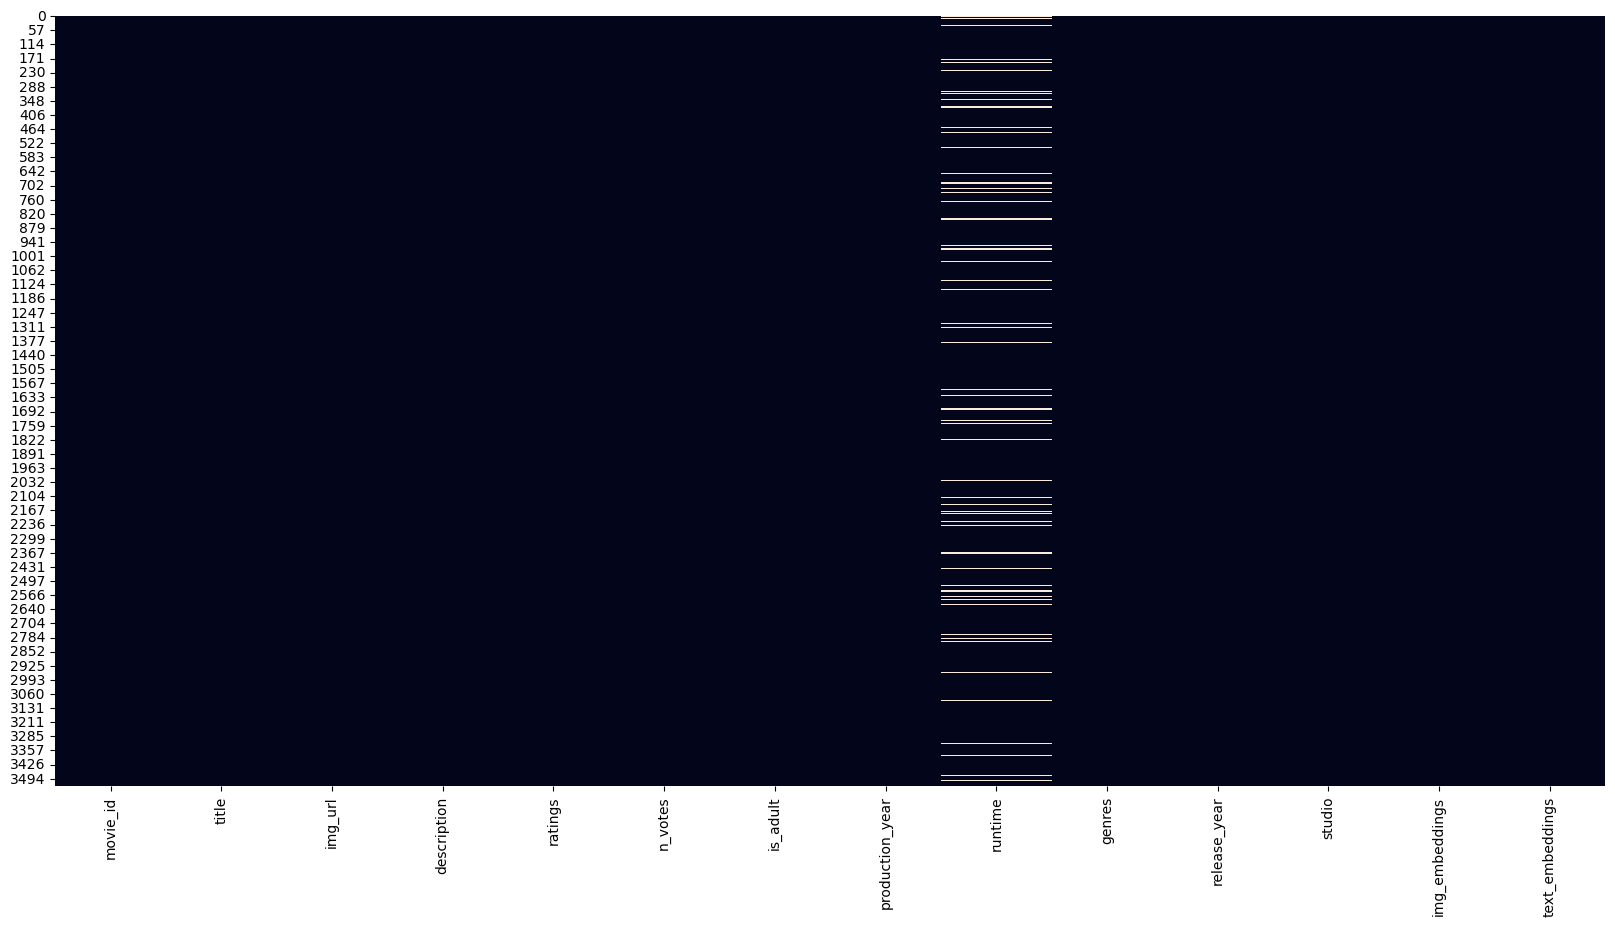

In [76]:
plt.figure(figsize = (20, 10))
sns.heatmap(X1.isna(), cbar = False)

Let's check the rows containing missing values

In [77]:
X1.loc[X1.isna().any(axis=1)]

,movie_id,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
9,7436,Change of Plans,https://m.media-amazon.com/images/M/MV5BMDFhZj...,Change of Plans: Directed by Randy Zisk. With ...,8.2,12.0,0,1992,NaN,"Crime,Drama",2010.0,IFC,"[0.20134872, 3.3128614, 1.3217659, 0.05505188,...","[-0.7538657, 0.43110898, 0.9997868, -0.9895797..."
38,7310,Clown,https://m.media-amazon.com/images/M/MV5BMjBiOD...,Clown: Directed by Steve Lyons. With Jeff Benn...,8.6,5.0,0,2001,NaN,"Animation,Comedy,Family",2016.0,W/Dim.,"[0.14516667, 0.06064418, 0.15632975, 0.1824489...","[-0.65403396, 0.3780646, 0.999505, -0.97987425..."
41,2655,Rugrats in Paris: The Movie,https://m.media-amazon.com/images/M/MV5BYzBiNW...,Rugrats in Paris: The Movie: With Cheryl Chase...,6.4,74.0,0,2000,NaN,"Action,Adventure,Comedy",2000.0,Par.,"[0.47641614, 0.82069486, 0.22295909, 0.1736825...","[-0.68661237, 0.37858504, 0.9997692, -0.978913..."
57,4639,In Bloom,https://m.media-amazon.com/images/M/MV5BYWNmZj...,In Bloom: Directed by Marc Buckland. With Neal...,8.4,16.0,0,2004,NaN,"Drama,Mystery",2014.0,BWP,"[0.30072853, 3.2013667, 0.42100322, 0.10732664...","[-0.787354, 0.46719107, 0.9998723, -0.9922189,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3463,2685,Noises Off,https://m.media-amazon.com/images/M/MV5BN2M4ZG...,Noises Off: Directed by Anthony Parker. With H...,7.1,7.0,0,1982,NaN,Comedy,1992.0,BV,"[0.010349306, 0.56857854, 0.63633597, 0.025205...","[-0.57973355, 0.3638104, 0.9994841, -0.9829557..."
3478,4912,The Star Maker,https://m.media-amazon.com/images/M/MV5BMjE3MD...,The Star Maker: Directed by Rod Amateau. With ...,8.5,25.0,0,1957,NaN,Comedy,1996.0,Mira.,"[0.1930125, 0.86812514, 1.0944237, 0.11855329,...","[-0.69110036, 0.39354154, 0.9996875, -0.983344..."
3496,1511,Dog Days of Summer,https://m.media-amazon.com/images/M/MV5BMjExNj...,"Dog Days of Summer: Directed by Chris Buck, Cl...",6.2,6.0,0,1993,NaN,"Animation,Comedy,Family",2008.0,MTop,"[0.21031177, 0.622036, 0.10827673, 0.14782186,...","[-0.672096, 0.35698575, 0.9996098, -0.98000515..."
3504,8584,Area 51,https://m.media-amazon.com/images/M/MV5BMjE4Nz...,"Area 51: With Tom Kane, Joerg Arnu, T.D. Barne...",5.7,6.0,0,2004,NaN,Documentary,2015.0,PARAIN,"[0.68146044, 1.8886466, 2.4086003, 0.9816384, ...","[-0.6459968, 0.31116134, 0.99957985, -0.981476..."


We have $0.3\%$ of entries with missing values for `genres` features. We can definitelty drop these entries.
However, for the `runtime` feature, we have ~ $7\%$ of missing values. That's a little bit much for removing all these entries.

We could try to impute by mean or something else.

/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0    90
Name: runtime, dtype: object


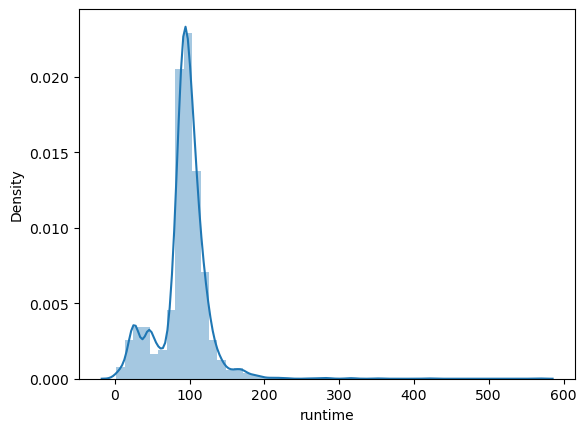

In [23]:
sns.distplot(X1["runtime"])

print(X1["runtime"].mode())

In [25]:
# Drop rows with NaN in genres column
X1.dropna(subset=["genres"], axis=0, inplace=True)

# TODO: impute rows with NaN in runtime column
X1["runtime"].fillna(X1["runtime"].mode(), inplace=True)

In [26]:
X1.isna().sum()

Unnamed: 0           0
title                0
img_url              0
description          0
ratings              0
n_votes              0
is_adult             0
production_year      0
runtime            261
genres               0
release_year         0
studio               0
img_embeddings       0
text_embeddings      0
dtype: int64

### Analysis of columns

/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

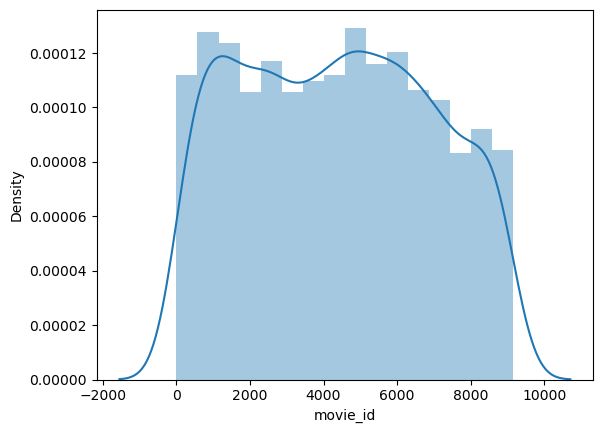

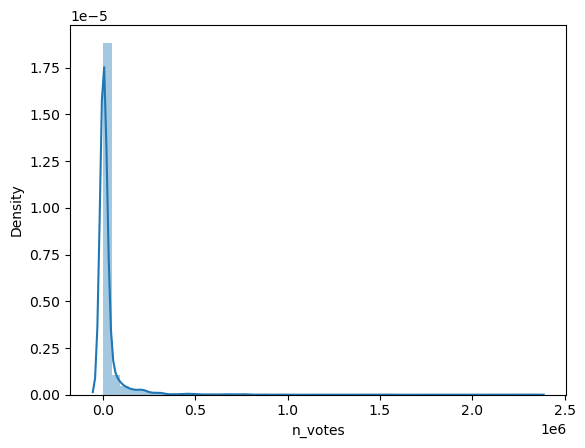

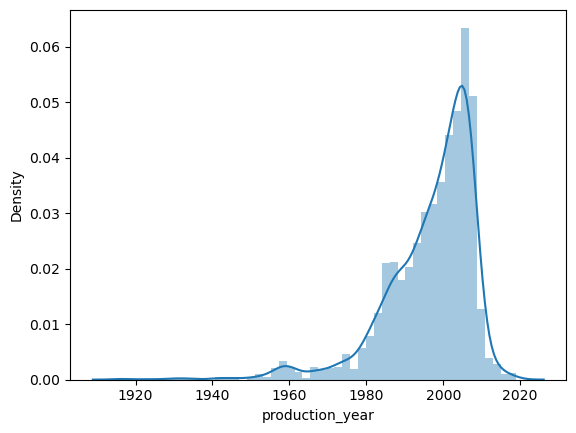

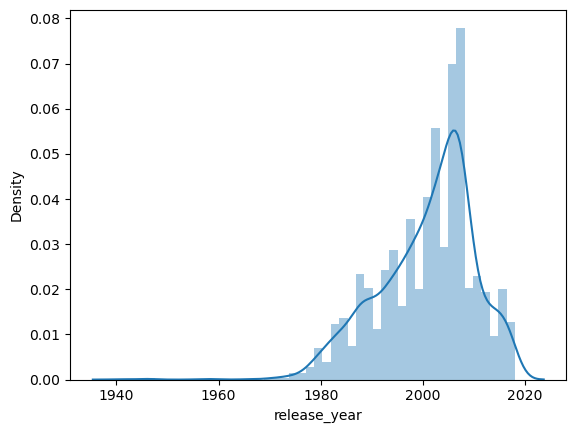

In [89]:
for col in X1.select_dtypes("int"):
    plt.figure()
    sns.distplot(X1[col])

There seems to be only _non-adult_ movies (to confirm later).

Movies were mainly produced between **1990** and **2010**. We have a left skewed distribution.

In [78]:
X1["is_adult"].value_counts()

0    3108
Name: is_adult, dtype: int64

Indeed, we **do not have any movies** for a _mature audience_. 
Therefore, we could drop this column.

In [79]:
X1.drop(["is_adult"], axis=1, inplace=True)
X1.head()

,movie_id,title,img_url,description,ratings,n_votes,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,2010,105,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,1978,127,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,1994,105,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,1982,108,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

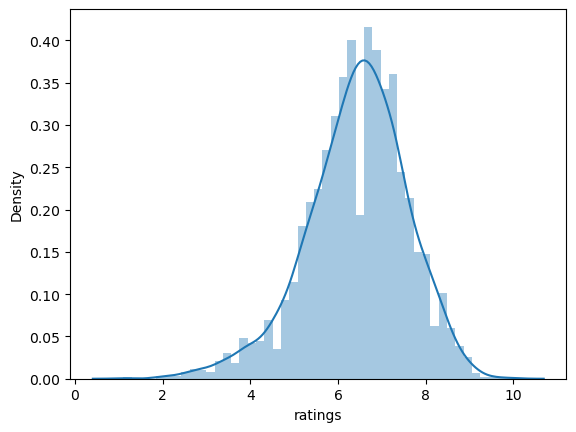

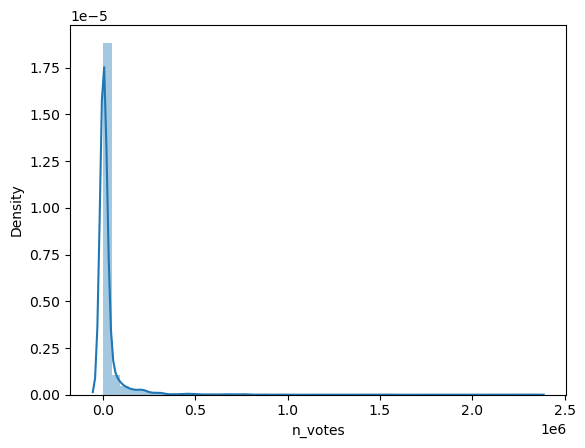

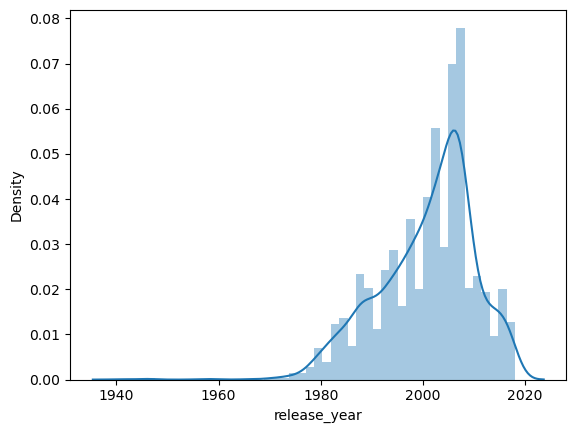

In [80]:
for col in X1.select_dtypes("float"):
    plt.figure()
    sns.distplot(X1[col])

Ratings are more or less normally distributed with a mean around **6.5**.

The number of votes are pretty homogeneous amoung the movies.

Most movies were released between **2005** and **2010**. We have a left skewed distribution.

It doesn't seem to make sense to have `n_votes` and `release_year` as "float". Let's convert them into "int".

In [81]:
X1["release_year"] = X1["release_year"].astype(int)
X1["n_votes"] = X1["n_votes"].astype(int)

X1.head()

,movie_id,title,img_url,description,ratings,n_votes,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937,2010,105,"Adventure,Comedy,Drama",2010,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11,1996,NaN,"Action,Crime,Drama",2014,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345,1978,127,"Drama,Family,Sport",1978,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851,1994,105,"Biography,Drama,Sport",1994,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549,1982,108,"Crime,Drama,Sport",1982,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


In [82]:
X1.index.is_unique

True

### Skewness, outliers and normalization

<AxesSubplot:>

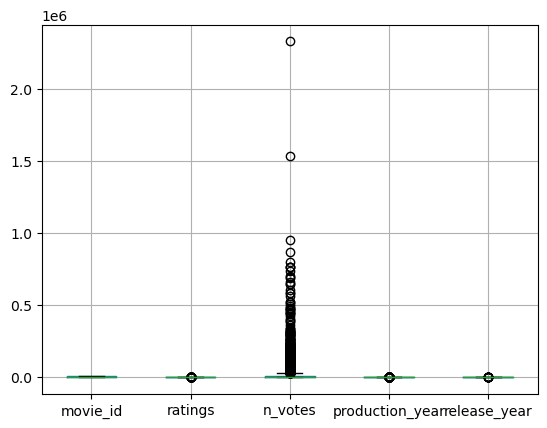

In [87]:
X1.boxplot()

We notice a big difference of scale for the `n_votes` feature. It also contains outliers. We do not remove outliers in testing set.

In [90]:
# TODO: remove outliers via IQR (because data has not normal shape)

Then, we standardize the data. To do that, we apply a scaler on the training set and then apply it on both training and testing sets.

In [27]:
scaler = StandardScaler()

X1_numerical_features = X1.select_dtypes(include=["int64", "float64"]).columns
X1_numerical_features = X1_numerical_features.difference(["movie_id"])
print(X1_numerical_features)

X1_scaled = scaler.fit_transform(X1[X1_numerical_features])
X1 = pd.DataFrame(X1_scaled, columns=X1.columns)
X1.head()

Index(['Unnamed: 0', 'is_adult', 'n_votes', 'production_year', 'ratings',
       'release_year'],
      dtype='object')


ValueError: Shape of passed values is (3536, 6), indices imply (3536, 14)

In [88]:
X1["n_votes"].describe()

count    3.108000e+03
mean     2.629159e+04
std      9.127364e+04
min      5.000000e+00
25%      1.960000e+02
50%      1.824500e+03
75%      1.208075e+04
max      2.332286e+06
Name: n_votes, dtype: float64

### One Hot Encoding

We should then One-Hot encode the genres

In [83]:
# separate all genres into one big list of list of genres
genres_list = X1["genres"].str.split(",").tolist()

unique_genres = []

# retrieve each genre
for sublist in genres_list:
    for genre in sublist:
        if genre not in unique_genres:
            unique_genres.append(genre)

# sort
unique_genres = sorted(unique_genres)
print(unique_genres)

# one hot encode movies genres
print(X1.columns.tolist())
X1 = X1.reindex(X1.columns.tolist() + unique_genres, axis = 1, fill_value = 0)
print(X1.head())

for index, row in X1.iterrows():
    for genre in row["genres"].split(","):
        X1.loc[index, genre] = 1

TypeError: 'float' object is not iterable

In [51]:
# drop old genres column
X1.drop("genres", axis=1, inplace=True)

X1.head()

,Unnamed: 0,title,img_url,description,ratings,n_votes,production_year,runtime,release_year,studio,...,Musical,Mystery,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937,2010,105,2010,Sum.,...,0,0,0,0,0,0,0,0,0,0
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345,1978,127,1978,MGM,...,0,0,0,0,0,0,1,0,0,0
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851,1994,105,1994,NL,...,0,0,0,0,0,0,1,0,0,0
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549,1982,108,1982,MGM,...,0,0,0,0,0,0,1,0,0,0
5,365,The Boondock Saints,https://m.media-amazon.com/images/M/MV5BNTliMT...,The Boondock Saints: Directed by Troy Duffy. W...,7.8,228296,1999,108,2000,Indic.,...,0,0,0,0,0,0,0,1,0,0


### Label Encoding

We should also One-Hot encode the `studio` feature. 
Well, there are a lof of different studios, therefore, it will result in a lof of features. Better to Label encode ?

In [52]:
X1["studio"].describe()

count     3275
unique     479
top         WB
freq       163
Name: studio, dtype: object

In [53]:
X1["studio"].unique()

array(['Sum.', 'MGM', 'NL', 'Indic.', 'Path.', 'Mira.', 'Uni.', 'Fox',
       'BV', 'Emr.', 'Tent.', 'FL', 'Par.', 'Run.', 'FoxA', 'BPic', 'OFI',
       'Icar.', 'Mont.', 'WB', 'ICir', 'Magn.', 'Strand', 'IFC', 'Palm',
       'SPC', 'Scre.', 'Truly', 'DW', 'Shem.', 'Outr.', 'Free', 'Castle',
       'Kath.', 'WIP', 'Reel', 'Org.', 'TriS', 'First', 'Lions', 'SM',
       'Orion', '600W', 'RadL', 'Cdgm.', 'Col.', 'Think', 'ParV', 'P/DW',
       'Gold.', 'NYer', 'Hale', 'RBF', 'RM', 'Skou', 'Avat.', 'RF', 'RA',
       'Art.', 'Lot47', 'Off-H', 'Istr', 'Isld', 'NEM', 'UTMW', 'CBS',
       'Sony', 'Villa', 'NCeV', 'ParC', 'Wein.', 'Anch.', 'JAR', 'Wine',
       'Hole.', 'CS', 'N.Arts', 'OutF', 'Slow', 'CLS', 'Gram.', 'MSP',
       'FoxS', 'Eros', 'Koch', 'Caval.', 'Key.', 'Hrtl', 'Leg.', 'FmC.',
       'All.', 'KL', 'DEJ', 'Relbig.', 'WB (NL)', 'NM', 'Triu', 'YFG',
       'PEC', 'Crnth', 'Arrow', 'Cn4', 'Tara', 'Oct.', 'Yash', 'Reg.',
       'Wildc.', 'Rog.', 'Comw', 'Emp.', 'Shoot.', 'LVR', 

In [28]:
label_encoder = LabelEncoder()

X1["studio"] = label_encoder.fit_transform(X1["studio"].values)

#X1 = pd.get_dummies(X1, columns=["studio"])
X1.head()

,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105,"Adventure,Comedy,Drama",2010.0,431,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,476,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127,"Drama,Family,Sport",1978.0,274,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105,"Biography,Drama,Sport",1994.0,310,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108,"Crime,Drama,Sport",1982.0,274,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


We could drop `title` feature as it doesn't have any value for the target (I guess)

In [56]:
X1.drop("title", axis=1, inplace=True)

KeyError: "['title'] not found in axis"

Let's analyse the distribution of the target training dataset

/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

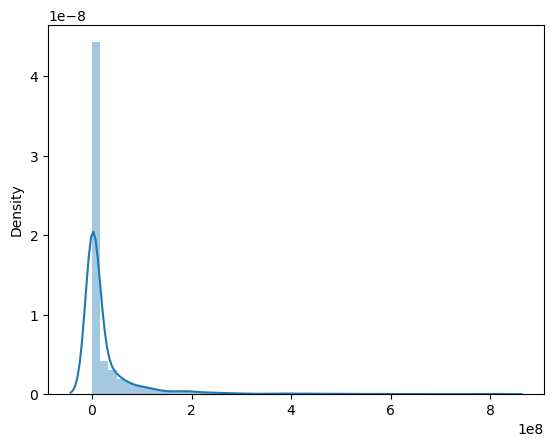

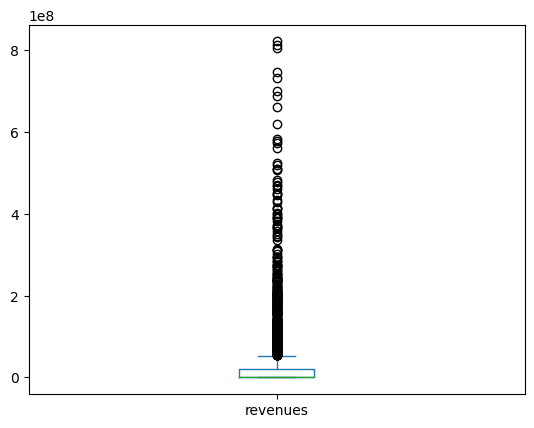

In [8]:
sns.distplot(Y1)

Y1.plot.box()

## Model

We're gonna build regression models :
- Linear regression
- K-Nearest Neighbors 
- MLP
- One other non-linear method (can be one not seen during the course)

We're gonna do **feature selection** and **model selection**.
/!\ model selection can require a lot of computation time /!\

We're gonna validate the model.

## Prediction

We're gonna make prediction about the revenue of movies present in `X2.csv`.